# Investigate Results
----
Load in `results` files and...
1. Generate **bar plots** of each link prediction method given an inputted network, visibility value (pct. hidden edges), and metric (e.g. test ROC), along with some pre-calculated network statistics (e.g. num. nodes, avg. clustering coefficient, etc.)
2. Plot **ROC curves** for inputted network, visibility, and link prediction method
3. **Save ROC AUC/AP plots** as .pdf files
4. **Save minimum runtime plots** as .pdf files
5. **Save network statistics** as .txt files
6. Generate **ROC Plots by Algorithm**
7. Generate **Twitter Results** Plots

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import link_prediction_scores as lp
import pickle

RANDOM_SEED = 0

## 1. Generate Bar Plots with Network Statistics

In [3]:
# Open FB results
fb_results = None
with open('./results/fb-experiment-4-results.pkl', 'rb') as f:
    fb_results = pickle.load(f)

# Generate bar plot given graph name (which ego network), frac_hidden, and metric to investigate (e.g. test ROC)
def bar_plot(graph_name, frac_hidden, metric):
    results_dict = fb_results['fb-{}-{}-hidden'.format(graph_name, frac_hidden)]
    metric_dict = {}
    for method, results_dict in results_dict.iteritems():
        metric_dict[method] = results_dict[metric]
        
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(metric_dict)), metric_dict.values())
    plt.xticks(range(len(metric_dict)), list(metric_dict.keys()))
    plt.grid(linestyle='dashed')
    plt.xlabel("Link prediction methods")
    plt.ylabel("Metric: {}".format(metric))
    plt.title("Link Prediction Results: FB {} graph, {} hidden".format(graph_name, frac_hidden))
    plt.show()

In [4]:
# Display network statistics for given network
def display_fb_network_statistics(graph_name):
    if graph_name == 'combined':
        graph_statistics_dir = './network-statistics/fb-combined-statistics.pkl'
    else:
        graph_statistics_dir = './network-statistics/fb-ego-{}-statistics.pkl'.format(graph_name)
    
    network_statistics = None
    with open(graph_statistics_dir, 'rb') as f:
        network_statistics = pickle.load(f)
        
    print 'FB Graph: ' + graph_name
    for statistic, value in network_statistics.iteritems():
        print statistic + ': ' + str(value)

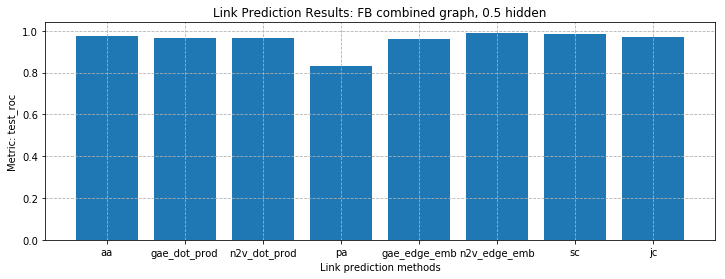

FB Graph: combined
diameter: 8
density: 0.0108199635034
avg_degree: 43.6910126269
num_edges: 88234
num_nodes: 4039
avg_clustering_coef: 0.60554671862
num_connected_components: 1
transitivity: 0.519174277543


In [5]:
# Display bar plot + network statistics
bar_plot('combined', 0.5, 'test_roc')
display_fb_network_statistics('combined')

## 3. Plot ROC Curves

In [6]:
# Plot ROC curve given graph_name, frac_hidden, and link prediction method (e.g. aa, for adamic-adar)
def show_roc_curve(graph_name, frac_hidden, method):
    results_dict = fb_results['fb-{}-{}-hidden'.format(graph_name, frac_hidden)]
    roc_curve = results_dict[method]['test_roc_curve']
    test_roc = results_dict[method]['test_roc']
    fpr, tpr, _ = roc_curve
        
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve:\nFB {} graph, {} hidden, {}'.format(graph_name, frac_hidden, method))
    plt.legend(loc="lower right")
    plt.show()

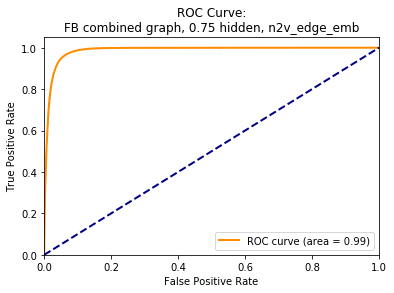

In [7]:
# Try it out!
show_roc_curve('combined', 0.75, 'n2v_edge_emb')

## 4. Save ROC AUC, AP Plots

In [8]:
FB_EXPERIMENT_NUM = 3
NX_EXPERIMENT_NUM = 2
METRICS = ['test_roc', 'test_ap']
RESULT_PLOTS_FOLDER = './result-plots-by-graph/'

# Load in FB results
fb_results_dict = None
with open('./results/fb-experiment-{}-results.pkl'.format(FB_EXPERIMENT_NUM), 'rb') as f:
    fb_results_dict = pickle.load(f)
    
# Load in NX results
nx_results_dict = None
with open('./results/nx-experiment-{}-results.pkl'.format(NX_EXPERIMENT_NUM), 'rb') as f:
    nx_results_dict = pickle.load(f)
    
# Combined dictionaries
all_results_dict = fb_results_dict.copy()
all_results_dict.update(nx_results_dict)

In [17]:
# Save bar plot in .pdf given metric name, metric dict (with results for each method), experiment name
def save_bar_plot(metric_name, metric_dict, experiment_name):
    if experiment_name[0:2] == 'fb': # e.g. fb-0-0.50-hidden
        descriptors = experiment_name.split('-')
        ego_num = descriptors[1]
        amt_hidden = descriptors[2]
        graph_title = "Link Prediction Results: FB-{} graph, {} hidden".format(ego_num, amt_hidden)
        
    elif experiment_name[0:2] == 'nx': # e.g. nx-sbm-small-0.25-hidden
        descriptors = experiment_name.split('-')
        graph_type = descriptors[1]
        graph_size = descriptors[2]
        amt_hidden = descriptors[3]
        graph_title = "Link Prediction Results: NX-{}-{} graph, {} hidden".format(graph_type, graph_size, amt_hidden)
        
    else:
        print 'Unknown graph type!'
        return
    
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(metric_dict)), metric_dict.values())
    plt.xticks(range(len(metric_dict)), list(metric_dict.keys()))
    plt.grid(linestyle='dashed')
    
    plt.xlabel("Link prediction methods")
    plt.ylabel("Metric: {}".format(metric_name))
    plt.title(graph_title)
    
    plt.savefig(RESULT_PLOTS_FOLDER + experiment_name + '-' + metric_name + '.pdf')
    plt.clf()

In [18]:
# Iterate over each experiment, generate plots for each relevant metric (e.g. test ROC, test AP)
for experiment_name, results_dict in all_results_dict.iteritems():
    # For each metric...
    for metric in METRICS:
        metric_dict = dict()
        
        # Populate metric_dict with results for each method
        for method, method_results_dict in results_dict.iteritems():
            metric_dict[method] = method_results_dict[metric]
        
        # Generate plot for this method and experiment name
        save_bar_plot(metric, metric_dict, experiment_name)

## 4. Save Minimum Runtime Plots

In [27]:
# Min. runtime dict: 
    # experiment_name (either FB or NX) --> link prediction method --> min. runtime
min_runtimes = {}

FB_EXPERIMENT_NUMS = [0, 1, 2, 3]
NX_EXPERIMENT_NUMS = [0, 1, 2]

# Iterate over all FB experiments, store minimum runtimes
for fb_num in FB_EXPERIMENT_NUMS:
    # Load in results for this experiment
    curr_fb_dict = None
    fb_filename = './results/fb-experiment-{}-results.pkl'.format(fb_num)
    with open(fb_filename, 'rb') as f:
        curr_fb_dict = pickle.load(f)
        
    # Iterate over experiments in curr_fb_dict
    for experiment, results in curr_fb_dict.iteritems():
        # Create (method --> runtime) dict, if necessary
        if experiment not in min_runtimes:
            min_runtimes[experiment] = {}
        
        # Iterate over link prediction methods in current network & experiment
        for method, metrics in results.iteritems():
            # Method currently has recorded runtime
            if method in min_runtimes[experiment]: 
                # Overwrite previous runtime
                if metrics['runtime'] < min_runtimes[experiment][method]:
                    min_runtimes[experiment][method] = metrics['runtime']
            # Method does not yet have recorded runtime
            else:
                min_runtimes[experiment][method] = metrics['runtime']
                    
# Iterate over all NX experiments, store minimum runtimes
for nx_num in NX_EXPERIMENT_NUMS:
    # Load in results for this experiment
    curr_nx_dict = None
    nx_filename = './results/nx-experiment-{}-results.pkl'.format(fb_num)
    with open(nx_filename, 'rb') as f:
        curr_nx_dict = pickle.load(f)
        
    # Iterate over experiments in curr_nx_dict
    for experiment, results in curr_nx_dict.iteritems():
        
        # Create (method --> runtime) dict, if necessary
        if experiment not in min_runtimes:
            min_runtimes[experiment] = {}
            
        # Remove gae_edge_emb results from NX experiments
        results['gae'] = results['gae_dot_prod']
        results.pop('gae_dot_prod')
        results.pop('gae_edge_emb')
        
        # Iterate over link prediction methods in current network & experiment
        for method, metrics in results.iteritems():
            # Method currently has recorded runtime
            if method in min_runtimes[experiment]: 
                # Overwrite previous runtime
                if metrics['runtime'] < min_runtimes[experiment][method]:
                    min_runtimes[experiment][method] = metrics['runtime']
            # Method does not yet have recorded runtime
            else:
                min_runtimes[experiment][method] = metrics['runtime']
                

In [28]:
# Plot runtime bar plots for all experiments
for experiment_name, runtime_dict in min_runtimes.iteritems():
    if experiment_name[0:2] == 'fb': # e.g. fb-0-0.50-hidden
        descriptors = experiment_name.split('-')
        ego_num = descriptors[1]
        amt_hidden = descriptors[2]
        graph_title = "Link Prediction Runtimes: FB-{} graph, {} hidden".format(ego_num, amt_hidden)
        
    elif experiment_name[0:2] == 'nx': # e.g. nx-sbm-small-0.25-hidden
        descriptors = experiment_name.split('-')
        graph_type = descriptors[1]
        graph_size = descriptors[2]
        amt_hidden = descriptors[3]
        graph_title = "Link Prediction Runtimes: NX-{}-{} graph, {} hidden".format(graph_type, graph_size, amt_hidden)
        
    else:
        print 'Unknown graph type!'
    
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(runtime_dict)), runtime_dict.values())
    plt.xticks(range(len(runtime_dict)), list(runtime_dict.keys()))
    plt.grid(linestyle='dashed')
    
    plt.xlabel("Link prediction methods")
    plt.ylabel("Minimum runtime (seconds)")
    plt.title(graph_title)
    
    plt.savefig('./result-plots-by-graph/' + experiment_name + '-runtime.pdf')
    plt.clf()

In [30]:
# Calculate average minimum runtimes for GAE, node2vec on 200- and 1000- node NX graphs
    # (Sum of all minimum runtimes / number of relevant experiments)
node2vec_200_total_seconds = 0
node2vec_1000_total_seconds = 0

gae_200_total_seconds = 0
gae_1000_total_seconds = 0

total_200_node_experiments = 0
total_1000_node_experiments = 0

for experiment_name, runtime_dict in min_runtimes.iteritems():
    if experiment_name[0:2] != 'nx':
        continue
        
    descriptors = experiment_name.split('-')
    graph_type = descriptors[1]
    graph_size = descriptors[2]
    amt_hidden = descriptors[3]
    
    if graph_size == 'small':
        node2vec_200_total_seconds += runtime_dict['n2v_edge_emb']
        gae_200_total_seconds += runtime_dict['gae']
        total_200_node_experiments += 1
        
    elif graph_size == 'large':
        node2vec_1000_total_seconds += runtime_dict['n2v_edge_emb']
        gae_1000_total_seconds += runtime_dict['gae']
        total_1000_node_experiments += 1
        
node2vec_200_avg_min_runtime = node2vec_200_total_seconds / total_200_node_experiments
node2vec_1000_avg_min_runtime = node2vec_1000_total_seconds / total_1000_node_experiments
gae_200_avg_min_runtime = gae_200_total_seconds / total_200_node_experiments
gae_1000_avg_min_runtime = gae_1000_total_seconds / total_1000_node_experiments

In [36]:
print "Node2Vec average min. runtime with 200 nodes: ", node2vec_200_avg_min_runtime
print "GAE average min. runtime with 200 nodes: ", gae_200_avg_min_runtime
print ''
print "Node2Vec average min. runtime with 1000 nodes: ", node2vec_1000_avg_min_runtime
print "GAE average min. runtime with 1000 nodes: ", gae_1000_avg_min_runtime

Node2Vec average min. runtime with 200 nodes:  2.13531324069
GAE average min. runtime with 200 nodes:  30.8872665246

Node2Vec average min. runtime with 1000 nodes:  12.4607275486
GAE average min. runtime with 1000 nodes:  39.0871587753


## 5. Save Network Statistics in .txt Files

In [13]:
import os
import pickle
STATS_FOLDER = "./network-statistics/"
stats_filenames = os.listdir(STATS_FOLDER)

# Loop over all files in folder
for filename in stats_filenames:
    # Not pickle file --> continue
    if filename[-4:] != '.pkl':
        continue
        
    # Read in pickled dictionary
    network_statistics = pickle.load(open(STATS_FOLDER + filename, 'rb'))
        
    # Store results in .txt
    txt_filename = filename[:-4] + '.txt' # replace '.pkl' with '.txt'
    with open('./network-statistics/'+txt_filename, 'w') as f:
        for statistic, value in network_statistics.iteritems():
            f.write(statistic + ': ' + str(value) + '\n')

## 6. ROC Charts by Algorithm

In [75]:
FB_EXPERIMENT_NUM = 3
NX_EXPERIMENT_NUM = 2
RESULT_PLOTS_FOLDER = './result-plots-by-algorithm/'

# Load in FB results
fb_results_dict = None
with open('./results/fb-experiment-{}-results.pkl'.format(FB_EXPERIMENT_NUM), 'rb') as f:
    fb_results_dict = pickle.load(f)
    
# Load in NX results
nx_results_dict = None
with open('./results/nx-experiment-{}-results.pkl'.format(NX_EXPERIMENT_NUM), 'rb') as f:
    nx_results_dict = pickle.load(f)
    
# Combined dictionaries
all_results_dict = fb_results_dict.copy()
all_results_dict.update(nx_results_dict)

In [14]:
# Mapping from algorithm abbreviation to full name
alg_abbr_to_name = {
    'aa': 'Adamic-Adar',
    'jc': 'Jaccard Coefficient',
    'n2v_dot_prod': 'Node2Vec with Dot-Product',
    'n2v_edge_emb': 'Node2Vec with Edge-Embeddings',
    'pa': 'Preferential Attachment',
    'sc': 'Spectral Clustering',
    'gae': 'Graph Auto-Encoder',
}

In [113]:
# Which graphs' results to investigate
GRAPH_NAMES = ['fb-combined', 'fb-0', 'nx-sbm-large', 'nx-ba-large', 'nx-ws-large', 'nx-er-large', 'nx-pc-large']

# Generate ROC bar plot over various graph types for a fixed link prediction algorithm and frac_hidden
def alg_results_bar_graph(lp_algorithm, frac_hidden, metric='test_roc', graph_names=GRAPH_NAMES, width=8):
    experiment_names = [graph + '-{}-hidden'.format(frac_hidden) for graph in graph_names]
    metric_pairs = [] # index 0: graph name; index 1: test ROC score
    for graph_name in graph_names:
        experiment_name = graph_name + '-{}-hidden'.format(frac_hidden)
        metric_val = all_results_dict[experiment_name][lp_algorithm][metric]
        metric_pairs.append((graph_name, metric_val))
        
    # Sort alphabetically by graph name
    metric_pairs = sorted(metric_pairs, key = lambda x: x[0])
    metric_values = [metric_pair[1] for metric_pair in metric_pairs]
    graph_names = [metric_pair[0] for metric_pair in metric_pairs]
    
    plt.clf()
    plt.figure(figsize=(width, 4))
    plt.bar(range(len(metric_pairs)), metric_values)
    plt.xticks(range(len(metric_pairs)), graph_names)
    plt.grid(linestyle='dashed')
    plt.xlabel("Network Type")
    plt.ylabel("Metric: {}".format('Test AUROC'))
    plt.title("Link Prediction Scores: {}, {}% edges hidden".format(alg_abbr_to_name[lp_algorithm], frac_hidden*100))
    plt.show()

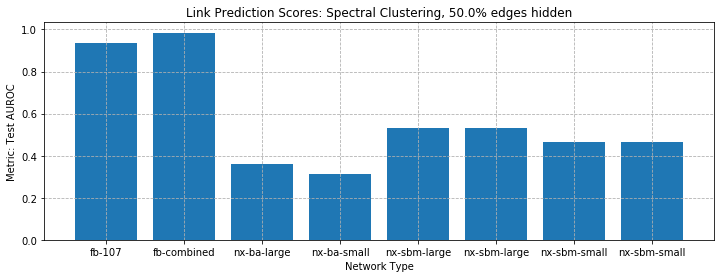

In [260]:
alg_results_bar_graph('sc', 0.50, \
                      graph_names=[
                        'fb-combined', \
                        'nx-sbm-large', 'nx-ba-large', 'nx-sbm-large',
                        'nx-sbm-small', 'nx-ba-small', 'nx-sbm-small'
                      ],
                     width=12)

# Include: fb-0, fb-combined, nx-ba-large, nx-sbm-large, (nx-ws-large)
# Ignore: erdos-renyi (too random, always 0.5 ROC), nx-pc (similar to ba), (nx-ws-large: very sparse)
# Notes:
    # Preferential attachment performs well on nx-ba
    # Spectral clustering performs poorly on nx-ba
    # Real-life networks have more structure to learn than random networks do
    # Larger networks have higher ROC scores (more data to learn from)

In [267]:
# Save each algorithm's AUROC bar plot in .pdf form
def save_alg_results_bar_graph(lp_algorithm, frac_hidden, metric='test_roc', graph_names=GRAPH_NAMES, sizes=None):
    experiment_names = [graph + '-{}-hidden'.format(frac_hidden) for graph in graph_names]
    metric_pairs = [] # index 0: graph name; index 1: test ROC score
    for graph_name in graph_names:
        experiment_name = graph_name + '-{}-hidden'.format(frac_hidden)
        metric_val = all_results_dict[experiment_name][lp_algorithm][metric]
        metric_pairs.append((graph_name, metric_val))
        
    # Sort alphabetically by graph name
    metric_pairs = sorted(metric_pairs, key = lambda x: x[0])
    metric_values = [metric_pair[1] for metric_pair in metric_pairs]
    graph_names = [metric_pair[0] for metric_pair in metric_pairs]
        
    # Generate figure
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(metric_pairs)), metric_values)
    plt.xticks(range(len(metric_pairs)), graph_names)
    plt.grid(linestyle='dashed')
    if sizes == 'small':
        xlabel = "Network Type (Small Graphs)"
    elif sizes == 'large':
        xlabel = "Network Type (Large Graphs)"
    else:
        xlabel = "Network Type"
    plt.xlabel(xlabel)
    plt.ylabel("Metric: {}".format('Test AUROC'))
    plt.title("Link Prediction Scores: {}, {}% edges hidden".format(alg_abbr_to_name[lp_algorithm], frac_hidden*100))
    
    # Save figure
    if sizes == 'small':
        img_dir = RESULT_PLOTS_FOLDER + str(lp_algorithm) + '-' + str(frac_hidden) + '-hidden-small.pdf'
    elif sizes == 'large':
        img_dir = RESULT_PLOTS_FOLDER + str(lp_algorithm) + '-' + str(frac_hidden) + '-hidden-large.pdf'
    else:
        img_dir = RESULT_PLOTS_FOLDER + str(lp_algorithm) + '-' + str(frac_hidden) + '-hidden.pdf'
    plt.savefig(img_dir)
    plt.clf()

In [271]:
# Generate AUROC graphs for each algorithm, frac_hidden
ALGORITHMS_TO_PLOT = alg_abbr_to_name.keys()
FRACS_HIDDEN = [0.25, 0.5, 0.75]
for alg in ALGORITHMS_TO_PLOT:
    for frac_hidden in FRACS_HIDDEN:
        save_alg_results_bar_graph(alg, frac_hidden, 
                    graph_names=['fb-combined', 'nx-er-large', 'nx-pc-large', 'nx-sbm-large', 'nx-ba-large', 'nx-ws-large'],
                                  sizes='large')
        save_alg_results_bar_graph(alg, frac_hidden, 
                    graph_names=['fb-348', 'nx-er-small', 'nx-pc-small', 'nx-sbm-small', 'nx-ba-small', 'nx-ws-small'],
                                  sizes='small')

## 7. Twitter Results Plots

### Runtime Plots

In [11]:
import os
import json
RESULTS_FOLDER = "./results/"

# Get minimum runtimes across Twitter experiments
twitter_min_runtimes = {}
TWITTER_EXPERIMENT_NUMS = [0, 1, 2]

# Iterate over all Twitter experiments, store minimum runtimes
for twitter_num in TWITTER_EXPERIMENT_NUMS:
    # Load in results for this experiment
    curr_fb_dict = None
    twitter_filename = './results/twitter-experiment-{}-results.json'.format(twitter_num)
    with open(twitter_filename, 'rb') as f:
        curr_twitter_dict = json.load(f)
        
    # Iterate over experiments in curr_twitter_dict
    for experiment, results in curr_twitter_dict.iteritems():
        # Create (method --> runtime) dict, if necessary
        if experiment not in twitter_min_runtimes:
            twitter_min_runtimes[experiment] = {}
        
        # Iterate over link prediction methods in current network & experiment
        for method, metrics in results.iteritems():
            # Method currently has recorded runtime
            if method in twitter_min_runtimes[experiment]: 
                # Overwrite previous runtime
                if metrics['runtime'] < twitter_min_runtimes[experiment][method]:
                    twitter_min_runtimes[experiment][method] = metrics['runtime']
            # Method does not yet have recorded runtime
            else:
                twitter_min_runtimes[experiment][method] = metrics['runtime']

In [13]:
# Plot runtime bar plots for all experiments
import matplotlib.pyplot as plt
for experiment_name, runtime_dict in twitter_min_runtimes.iteritems():
    descriptors = experiment_name.split('-')
    ego_num = descriptors[1]
    amt_hidden = descriptors[2]
    graph_title = "Link Prediction Runtimes: Twitter-{} graph, {} hidden".format(ego_num, amt_hidden)
    
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(runtime_dict)), runtime_dict.values())
    plt.xticks(range(len(runtime_dict)), list(runtime_dict.keys()))
    plt.grid(linestyle='dashed')
    
    plt.xlabel("Link prediction methods")
    plt.ylabel("Minimum runtime (seconds)")
    plt.title(graph_title)
    
    plt.savefig('./result-plots-by-graph/' + experiment_name + '-runtime.pdf')
    plt.clf()

### ROC AUC Plots

In [22]:
# Save bar plot in .pdf given metric name, metric dict (with results for each method), experiment name
RESULT_PLOTS_FOLDER = './result-plots-by-graph/'
twitter_results = None
with open('./results/twitter-experiment-0-results.json', 'rb') as f:
    twitter_results = json.load(f)
    
# Save Twitter results bar plot
def save_twitter_bar_plot(metric_name, metric_dict, experiment_name):
    descriptors = experiment_name.split('-')
    ego_num = descriptors[1]
    amt_hidden = descriptors[2]
    graph_title = "Link Prediction Results: Twitter-{} graph, {} hidden".format(ego_num, amt_hidden)
    
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(metric_dict)), metric_dict.values())
    plt.xticks(range(len(metric_dict)), list(metric_dict.keys()))
    plt.grid(linestyle='dashed')
    
    plt.xlabel("Link prediction methods")
    plt.ylabel("Metric: {}".format(metric_name))
    plt.title(graph_title)
    
    plt.savefig(RESULT_PLOTS_FOLDER + experiment_name + '-' + metric_name + '.pdf')
    plt.clf()
    
# Plot ROC AUC bar graphs for each amt_hidden
for experiment_name, results_dict in twitter_results.iteritems():
    roc_dict = dict()
        
    # Populate metric_dict with results for each method
    for method, method_results_dict in results_dict.iteritems():
        roc_dict[method] = method_results_dict['test_roc']

    # Generate plot for this method and experiment name
    save_twitter_bar_plot("test_roc", roc_dict, experiment_name)